In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('./datasets/data_n200_N200.csv',sep=',',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,NaN,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200
1,1.0,5,2,1,3,10,6,7,4,8,...,194,184,198,189,193,197,199,196,195,200
2,2.0,13,4,2,1,3,7,8,5,6,...,197,182,198,188,191,196,200,193,194,199
3,3.0,13,1,2,3,8,4,5,7,15,...,200,180,195,191,186,197,198,193,190,199
4,4.0,11,3,2,1,10,4,6,8,14,...,199,183,195,184,185,194,197,191,187,200


In [3]:
data_arr = np.array(df.loc[1:,1:],dtype=int)
#data_arr = np.concatenate((data_arr,data_arr))
#data_arr = np.concatenate((data_arr,data_arr))
#data_arr = np.concatenate((data_arr,data_arr))
#data_arr = np.concatenate((data_arr,data_arr))
#data_arr = np.concatenate((data_arr,data_arr))
n =data_arr.shape[1]
N =data_arr.shape[0]

In [4]:
def generate_V(centre):
    centre_arr = np.array(centre)
    n = len(centre_arr)
    V_order = np.zeros(n)
    distToCentre = V_order
    distToCentre = centre_arr - (np.max(centre_arr)+1)/2
    if(n%2):
        V_order[distToCentre==0] = 1
    for i in distToCentre[distToCentre>0]:
        if (np.random.rand()>0.5):
            V_order[distToCentre == i] = np.abs(i)*2+1
            V_order[distToCentre == -i] = np.abs(i)*2
        else:
            V_order[distToCentre == i] = np.abs(i)*2
            V_order[distToCentre == -i] = np.abs(i)*2+1
            
    return V_order

In [5]:
def rank(ls):
    arr = np.array(ls)
    ordering = np.argsort(arr)
    ranks = np.empty_like(ordering)
    ranks[ordering] = np.arange(len(arr))+1
    return ranks

In [6]:
def pseudo_likelihood(data,n_samples,alpha):
    data_arr = np.array(data)
    N = data_arr.shape[0]
    n = data_arr.shape[1]
    rho_samples = np.zeros((n_samples,n),dtype=int)
    data_rank = rank(np.sum(data_arr,axis=0))
    for i in range(n_samples): #should be easily parallelized?
        if((i+1)%100==0):
            print(i+1 ,"/", n_samples, "iterations")
        support = np.arange(0,n)
        rho_tmp = np.zeros(n, dtype = int)
        V_centre = generate_V(data_rank)
        #V_centre = np.arange(1,n+1)
        for j in range(n):
            i_curr = np.where(V_centre ==(j+1))
            ####calculating the distance from the data to the possible value
            dists = np.array(list(map(lambda x: np.sum(np.abs(data_arr[:,i_curr].ravel() - x)),(support+1))))
            #different implementation with vectorize, so far don't seem to improve performance
            #distfunc = np.vectorize(lambda x: np.sum(np.abs(data_arr[:,i_curr].ravel() - x)))
            #dists = distfunc(support+1)
            log_num =(-alpha/(n)*(dists)) - np.max(-alpha/(n)*(dists))  #minus the max to stablize the exponential term
            log_denom = np.log(np.sum(np.exp(log_num)))
            ###to be very sure that it sums to one, therefore devide by its sum
            probs= np.exp((log_num-log_denom)) / np.sum(np.exp((log_num-log_denom))) 
            index = int(np.where(np.random.multinomial(n=1, pvals = probs)==1)[0])
            rho_tmp[i_curr] = support[index]
            support = support[support!=rho_tmp[i_curr]]
       
        rho_samples[i,:] = rho_tmp+1
           
    return rho_samples


In [7]:
def pseudo_rho(data,alpha):
    
    data_arr = np.array(data)
    N = data_arr.shape[0]
    n = data_arr.shape[1]
    rho_samples = np.zeros((n_samples,n),dtype=int)
    data_rank = rank(np.sum(data_arr,axis=0))
    support = np.arange(0,n)
    rho_tmp = np.zeros(n, dtype = int)
    V_centre = generate_V(data_rank)
    for j in range(n):
        i_curr = np.where(V_centre ==(j+1))
        ####calculating the distance from the data to the possible value
        dists = np.array(list(map(lambda x: np.sum(np.abs(data_arr[:,i_curr].ravel() - x)),(support+1))))
        #different implementation with vectorize, so far don't seem to improve performance
        #distfunc = np.vectorize(lambda x: np.sum(np.abs(data_arr[:,i_curr].ravel() - x)))
        #dists = distfunc(support+1)
        log_num =(-alpha/(n)*(dists)) - np.max(-alpha/(n)*(dists))  #minus the max to stablize the exponential term
        log_denom = np.log(np.sum(np.exp(log_num)))
        ###to be very sure that it sums to one, therefore devide by its sum
        probs= np.exp((log_num-log_denom)) / np.sum(np.exp((log_num-log_denom))) 
        index = int(np.where(np.random.multinomial(n=1, pvals = probs)==1)[0])
        rho_tmp[i_curr] = support[index]
        support = support[support!=rho_tmp[i_curr]]
        
    return (rho_tmp+1)

In [11]:
import time
start= time.time()
pseudo_rho(data_arr,1)
end = time.time()
print("obtain one sample", np.round(end - start,5),"seconds elapsed")
        

obtain one sample 0.21505 seconds elapsed


In [12]:
n_samples = 3000
import time
start = time.time()
rho_samples=pseudo_likelihood(data_arr,n_samples,2.)
end = time.time()
#print(end-start)
print(np.round(end - start,3),"seconds elapsed")

KeyboardInterrupt: 

In [50]:
rho_samples.shape

(3000, 20)

In [51]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear in the bottom.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


In [53]:
heatMat=(np.array(list(map(lambda x: np.sum(rho_samples == x,axis=0), (np.arange(1,1+n)))))/n_samples)[::-1]

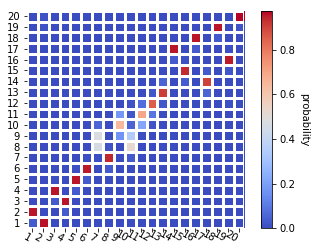

In [54]:
fig, ax = plt.subplots()
im, cbar = heatmap(heatMat, reversed(np.arange(1,n+1)), (np.arange(1,n+1)), ax=ax,
                   cmap="coolwarm", cbarlabel= "probability")

In [55]:
#fig, ax = plt.subplots()
#im = ax.imshow(heatMat)

In [56]:
df_potatoes = pd.read_csv('./datasets/potato.csv',sep=',',header=None)
df_potatoes.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,NaN,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20
1,A1,10,18,19,15,6,16,4,20,3,...,12,1,2,9,17,8,7,14,13,11
2,A2,10,18,19,17,11,15,6,20,4,...,13,1,2,7,16,8,5,12,9,14
3,A3,12,15,18,16,13,11,7,20,6,...,8,2,1,4,19,5,9,14,10,17
4,A4,9,17,19,16,10,15,5,20,3,...,8,1,2,7,18,11,6,13,14,12


In [57]:
potato_arr = np.array(df_potatoes.loc[1:,1:],dtype=int)

In [58]:
potato_arr

array([[10, 18, 19, 15,  6, 16,  4, 20,  3,  5, 12,  1,  2,  9, 17,  8,
         7, 14, 13, 11],
       [10, 18, 19, 17, 11, 15,  6, 20,  4,  3, 13,  1,  2,  7, 16,  8,
         5, 12,  9, 14],
       [12, 15, 18, 16, 13, 11,  7, 20,  6,  3,  8,  2,  1,  4, 19,  5,
         9, 14, 10, 17],
       [ 9, 17, 19, 16, 10, 15,  5, 20,  3,  4,  8,  1,  2,  7, 18, 11,
         6, 13, 14, 12],
       [12, 17, 19, 15,  7, 16,  2, 20,  3,  9, 13,  1,  4,  5, 18, 11,
         6,  8, 10, 14],
       [10, 15, 19, 16,  8, 18,  6, 20,  3,  7, 11,  1,  2,  4, 17,  9,
         5, 13, 12, 14],
       [ 9, 16, 19, 17, 10, 15,  5, 20,  3,  8, 11,  1,  2,  6, 18,  7,
         4, 14, 12, 13],
       [14, 18, 20, 19, 11, 15,  6, 17,  4,  3, 10,  1,  2,  7, 16,  8,
         5, 12,  9, 13],
       [ 8, 16, 18, 19, 12, 13,  6, 20,  5,  3,  7,  1,  4,  2, 17, 10,
         9, 15, 14, 11],
       [ 7, 17, 19, 18,  9, 15,  5, 20,  3, 10, 11,  1,  2,  6, 16,  8,
         4, 13, 12, 14],
       [12, 16, 19, 15, 13, 18

In [59]:
n_samples = 3000
start = time.time()
rho_samples=pseudo_likelihood(potato_arr,n_samples,16.)
end = time.time()
#print(end-start)
print(np.round(end - start,3),"seconds elapsed")

100 / 3000 iterations
200 / 3000 iterations
300 / 3000 iterations
400 / 3000 iterations
500 / 3000 iterations
600 / 3000 iterations
700 / 3000 iterations
800 / 3000 iterations
900 / 3000 iterations
1000 / 3000 iterations
1100 / 3000 iterations
1200 / 3000 iterations
1300 / 3000 iterations
1400 / 3000 iterations
1500 / 3000 iterations
1600 / 3000 iterations
1700 / 3000 iterations
1800 / 3000 iterations
1900 / 3000 iterations
2000 / 3000 iterations
2100 / 3000 iterations
2200 / 3000 iterations
2300 / 3000 iterations
2400 / 3000 iterations
2500 / 3000 iterations
2600 / 3000 iterations
2700 / 3000 iterations
2800 / 3000 iterations
2900 / 3000 iterations
3000 / 3000 iterations
8.849 seconds elapsed


In [60]:
potato_true_ranking = np.array([11, 17, 19, 16, 10, 15,  5, 20,  3,  4,  9,  1,  2,  6, 18,  7,  8,
       14, 12, 13])
potato_ordering = np.argsort(potato_true_ranking)
rho_samples_ordered = rho_samples[:,potato_ordering]

In [61]:
heatMat_potatoes=(np.array(list(map(lambda x: np.sum(rho_samples[:,potato_ordering] == x,axis=0), np.arange(1,n+1))))/n_samples)[::-1]

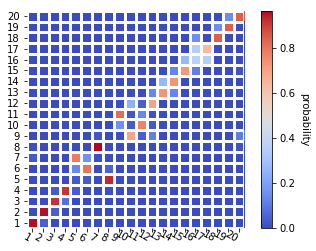

In [62]:
fig, ax = plt.subplots()
im, cbar = heatmap(heatMat_potatoes, reversed(np.arange(1,n+1)), (np.arange(1,n+1)), ax=ax,
                   cmap="coolwarm", cbarlabel= "probability")

In [152]:
def dist_func(vec1, vec2):
    result = np.array(list(map(lambda x: np.sum(np.abs(vec1.ravel() - x)),vec2)))
    return result

In [153]:
dist_func(data_arr[:,0], support+1)

array([2364, 2176, 2008, 1852, 1714, 1592, 1496, 1420, 1368, 1336, 1326,
       1336, 1356, 1392, 1452, 1524, 1618, 1726, 1844, 1970])

In [145]:
def pseudo_rho2(data,alpha):
    data_arr = np.array(data)
    N = data_arr.shape[0]
    n = data_arr.shape[1]
    rho_samples = np.zeros((n_samples,n),dtype=int)
    data_rank = rank(np.sum(data_arr,axis=0))
    support = np.arange(0,n)
    rho_tmp = np.zeros(n, dtype = int)
    V_centre = generate_V(data_rank)
    all_dists = np.apply_along_axis(dist_func,0,data_arr,vec2 = support+1)
    for j in range(n):
        i_curr = np.where(V_centre ==(j+1))
        ####calculating the distance from the data to the possible value
        dists = all_dists[support,:][:,i_curr].ravel()
        #different implementation with vectorize, so far don't seem to improve performance
        #distfunc = np.vectorize(lambda x: np.sum(np.abs(data_arr[:,i_curr].ravel() - x)))
        #dists = distfunc(support+1)
        log_num =(-alpha/(n)*(dists)) - np.max(-alpha/(n)*(dists))  #minus the max to stablize the exponential term
        log_denom = np.log(np.sum(np.exp(log_num)))
        ###to be very sure that it sums to one, therefore devide by its sum
        probs= np.exp((log_num-log_denom)) / np.sum(np.exp((log_num-log_denom))) 
        index = int(np.where(np.random.multinomial(n=1, pvals = probs)==1)[0])
        rho_tmp[i_curr] = support[index]
        support = support[support!=rho_tmp[i_curr]]
        
    return (rho_tmp+1)

In [162]:
N = data_arr.shape[0]
n = data_arr.shape[1]
rho_samples = np.zeros((n_samples,n),dtype=int)
data_rank = rank(np.sum(data_arr,axis=0))
support = np.arange(0,n)
rho_tmp = np.zeros(n, dtype = int)
V_centre = generate_V(data_rank)
all_dists = np.apply_along_axis(dist_func,0,data_arr,vec2 = support+1)



In [154]:
all_dists = np.apply_along_axis(dist_func,0,data_arr,vec2 = support+1)

In [166]:
support

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [158]:
all_dists[:,1]

array([3566, 3374, 3204, 3058, 2932, 2816, 2718, 2644, 2584, 2530, 2492,
       2464, 2444, 2430, 2418, 2408, 2404, 2406, 2418, 2434])